Correlating boiling point data using simple linear regression, multivariate regression, and deep learning using PyTorch  

In [99]:
import pandas as pd
from matplotlib import pyplot as plt
from scipy import stats
import numpy as np
import random
import torch
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable

# extracts data from an excel file
def data_extractor(column_values=None, filename='excel-data.xlsx'):
    raw_data = pd.read_excel(filename)
    column_names = raw_data.columns.values
    column_values = []
    for i in range(0, len(raw_data.columns)):
        column_values.append(np.array(raw_data[raw_data.columns[i]].values))
    return column_names, column_values


# given a set of experimental label data and predicted label data, returns R^2 and AAD
def fit_evaluator(label, label_correlation):
    SS_residual = np.sum((label - label_correlation) ** 2)
    SS_total = (len(label) - 1) * np.var(label)
    R_squared = 1 - (SS_residual / SS_total)
    AAD = 100 * ((1 / len(label)) * np.sum(abs(label - label_correlation) / label))
    return np.round(R_squared,decimals=2), np.round(AAD,decimals=2)


# plots a linear fit obtained using np.linregress alongside experimental data
def linear_plotter(x, y, fit_params, x_label='Molecular weight', y_label='Boiling temperature /K'):
    plt.scatter(x, y, s=1, label='Experimental data')
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    x_range = np.linspace(min(x), max(x), 3)
    m = fit_params[0]
    c = fit_params[1]
    y_correlation= y * m + c
    R_sq, AAD = fit_evaluator(y, y_correlation)
    plt.plot(x_range, x_range * m + c, label='Straight-line fit \n R^2={} AAD ={}'.format(fit_params[2] ** 2, AAD))
    plt.legend()


# performs a linear regression on (x, y)
def linear_regression(x, y):
    linear_fit = stats.linregress(x, y)  # linear_fit is now a tuple with [gradient, intercept, R, ...]
    return linear_fit


# this function uses matrix algebra to obtain coefficients (in matrix theta) for linear fit of any number of features
# against a label, such that: label = theta_0 * 1 + theta_1 * feature_1 + ... + theta_N * feature_N
# ie. Y (100 by 1) = X (100 by 3) * THETA (3 by 1) => THETA = inverse (X * X^T) * X * X^T * Y
def multivariate_correlator(features, label):
    training_range = random.sample(range(0, len(label)), int(0.1 * len(label)))
    X = pd.DataFrame([np.ones(len(training_range))])
    for item in features:
        feature_data = pd.DataFrame(item[training_range]).transpose()
        X = X.append(feature_data)
    X = X.transpose()
    Y = label[training_range]
    inverse_target = (X.transpose().dot(X))
    target_inversed = pd.DataFrame(np.linalg.pinv(inverse_target.values), inverse_target.columns, inverse_target.index)
    theta = target_inversed.dot(X.transpose()).dot(Y)
    return theta


# takes features and theta and spits out label values for whole set of features
def multivariate_model(features, theta):
    X = pd.DataFrame([np.ones(len(features[0]))])
    for item in features:
        feature_data = pd.DataFrame(item).transpose()
        X = X.append(feature_data)
    Y = X.transpose().dot(theta)
    return Y


# plots experimental data (x,y) and correlation, given features with coefficients stored in theta
def correlation_plotter(x, y, features, theta, x_label='Molecular weight', y_label='Reduced boiling temperature'):
    y_correlation=multivariate_model(features,theta)
    R_sq, AAD = fit_evaluator(y, y_correlation)
    plt.scatter(x, y, s=1, label='Experimental data points')
    plt.scatter(x, y_correlation, s=1, label='Empirical correlation \n R^2:{} AAD:{}'.format(R_sq, AAD))
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend()


# prepares data for neural_network_trainer()
def neural_network_input_data_creator(features, label):
    sub_range_size=int(0.1 * len(label))
    training_range = random.sample(range(0, len(label)), sub_range_size)
    test_range = random.sample(list(x for x in list(range(0, len(label))) if x not in training_range), sub_range_size)
    validation_range = list(z for z in list(range(0, len(label))) if z not in (training_range, test_range))
    X = pd.DataFrame()
    for item in features:
        feature_data = pd.DataFrame(item[training_range]).transpose()
        X = X.append(feature_data)
    X = torch.tensor(X.transpose().values).float()
    Y = torch.tensor(label[training_range]).float()
    Y = Y.reshape([Y.size()[0],1], 1)
    return X, Y, training_range, test_range, validation_range


# creating a NeuralNet class and defining net properties to train a model to take features=>label
# creating a NeuralNet class to train a model to take features=>label
class NeuralNet(nn.Module):
    def __init__(self, input_neurons, output_neurons, hidden_neurons):
        super(NeuralNet, self).__init__()
        self.layer = nn.Sequential(
                        nn.Linear(input_neurons, hidden_neurons),
                        nn.ReLU(),
                        nn.Linear(hidden_neurons, hidden_neurons),
                        nn.ReLU(),
                        nn.Linear(hidden_neurons, output_neurons)
                          )
    def forward(self,x):
        x=self.layer(x)
        return x

# trains a neural network to predict y (prepared from label data) based on x (prepared from feature data)
def neural_network_trainer(x, y, hidden_neurons=5,learning_rate=0.001,epochs=500):
    # setting model parameters
    input_neurons = x.shape[1]
    output_neurons = 1
    model = NeuralNet(input_neurons,output_neurons,hidden_neurons)
    print(model)
    #loss_func = torch.nn.BCEWithLogitsLoss()
   #loss_func = torch.nn.CrossEntropyLoss()
    loss_func = torch.nn.MSELoss()
    optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate)
    x = Variable(x)
    y = Variable(y)
    model.train()
    for epoch in range(epochs):
        y_pred = model(x) # forward pass
        loss = loss_func(y_pred,y)  # computing loss
        optimizer.zero_grad()   # optimising and updating weights
        loss.backward()  # backward pass
        optimizer.step()    # updating parameters
        if epoch % 25 == 0:         # plotting and showing learning process
            print('epoch: {}; loss: {}'.format(epoch, loss.item()))
            plt.cla()
            plt.scatter(x[:,0].data.numpy(), y.data.numpy())
            plt.scatter(x[:,0].data.numpy(), y_pred.data.numpy())
            plt.text(0.5, 0, 'Loss=%.4f' % loss.data.numpy(), fontdict={'size': 10, 'color': 'red'})
            plt.pause(0.1)
    return model


# takes the trained neural network with accompanying data and evaluates the model based on subset of data
# can be used for testing and validation
# def neural_network_evaluator(x, y, drange, features, model, x_label='Molecular weight', y_label = 'Reduced boiling temperature'):
#     test_feature_input = torch.tensor([features[0][drange], features[1][drange]]).float()
#     y_correlation = model(test_feature_input)
#     R_sq, AAD = fit_evaluator(y[drange], y_correlation)
#     plt.title('Testing neural network fit')
#     plt.scatter(x[drange], y[drange], s=1, label='Experimental data points')
#     plt.scatter(x[drange], y_correlation, s=1, label='ANN model \n R^2:{} AAD:{}'.format(R_sq, AAD))
#     plt.xlabel(x_label)
#     plt.ylabel(y_label)
#     plt.legend()


calling functions and starting  operations

In [100]:
#def main():
# extracting data
(data_headers, data_values) = data_extractor()
mol_weight = data_values[np.where(data_headers == 'molweight')[0][0]]
crit_temp = data_values[np.where(data_headers == 'critical temperature (K)')[0][0]]
boil_point = data_values[np.where(data_headers == 'boiling point (K)')[0][0]]
acentric_factor = data_values[np.where(data_headers == 'acentric factor')[0][0]]

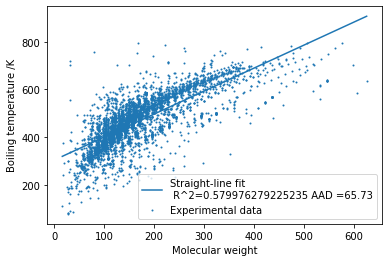

In [101]:
# plotting raw data and carrying out and plotting a linear regression
plt.figure(1)
linear_fit = linear_regression(mol_weight, boil_point)
linear_plotter(mol_weight, boil_point, linear_fit)

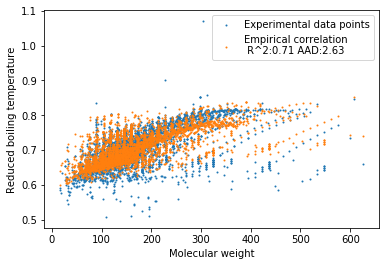

In [102]:
# now correlating a reduced boiling temperature, y = Tb/Tc, against o (acentric factor) and MW, using a simple
# linear coefficient model, then plotting
plt.figure(2)
reduced_temp = boil_point / crit_temp
features = [mol_weight, acentric_factor]
theta = multivariate_correlator(features, reduced_temp)
correlation_plotter(mol_weight, reduced_temp, features, theta)

NeuralNet(
  (layer): Sequential(
    (0): Linear(in_features=2, out_features=5, bias=True)
    (1): ReLU()
    (2): Linear(in_features=5, out_features=5, bias=True)
    (3): ReLU()
    (4): Linear(in_features=5, out_features=1, bias=True)
  )
)
epoch: 0; loss: 31.99929428100586
epoch: 25; loss: 0.14142829179763794
epoch: 50; loss: 0.12816931307315826
epoch: 75; loss: 0.11617346107959747
epoch: 100; loss: 0.10532037913799286
epoch: 125; loss: 0.09550117701292038
epoch: 150; loss: 0.0866173803806305
epoch: 175; loss: 0.0785798653960228
epoch: 200; loss: 0.07130806893110275
epoch: 225; loss: 0.06472901999950409
epoch: 250; loss: 0.05877665802836418
epoch: 275; loss: 0.053391315042972565
epoch: 300; loss: 0.04851903021335602
epoch: 325; loss: 0.04411087557673454
epoch: 350; loss: 0.04012266546487808
epoch: 375; loss: 0.03651430830359459
epoch: 400; loss: 0.03324976563453674
epoch: 425; loss: 0.03029622510075569
epoch: 450; loss: 0.027623988687992096
epoch: 475; loss: 0.02520630694925785


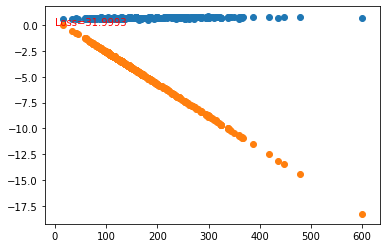

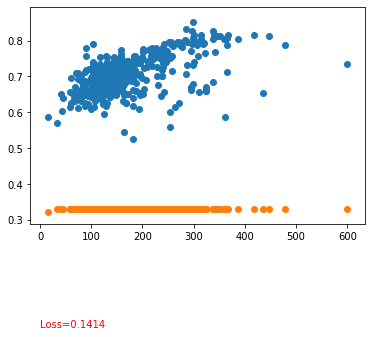

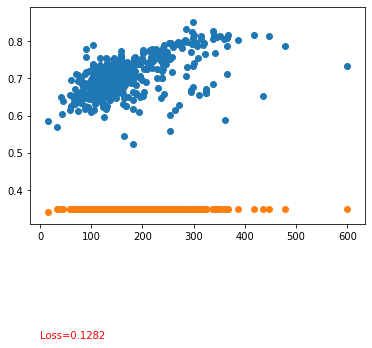

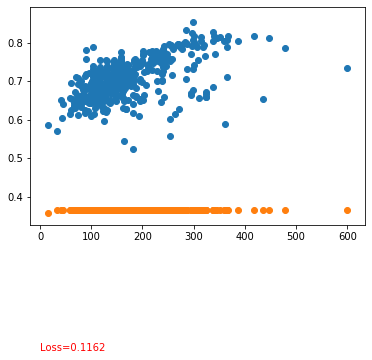

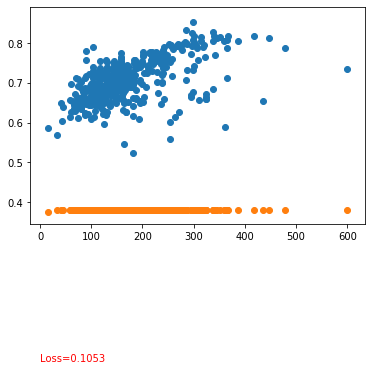

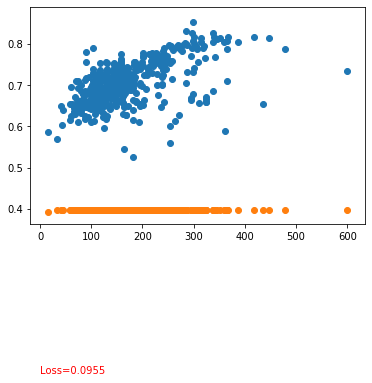

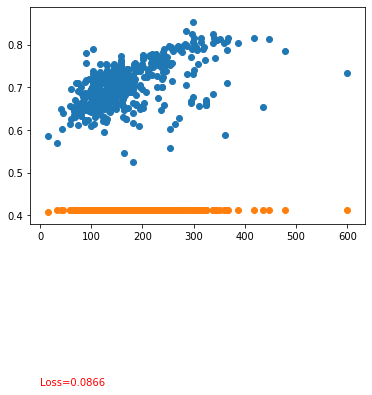

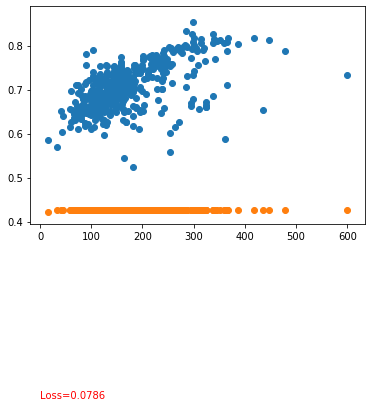

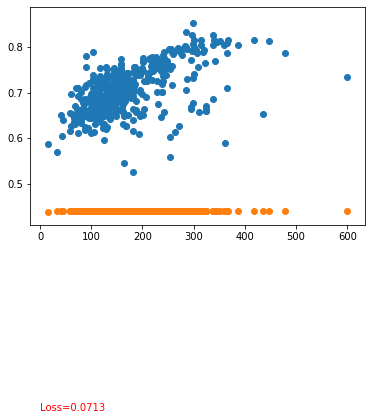

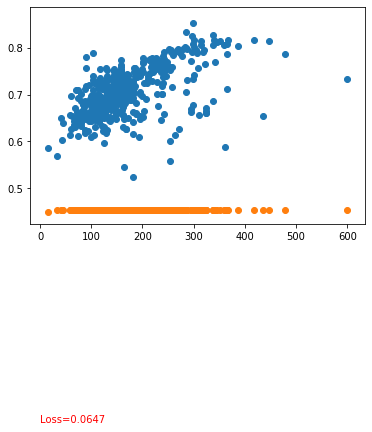

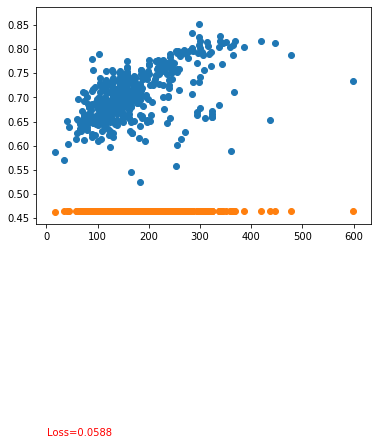

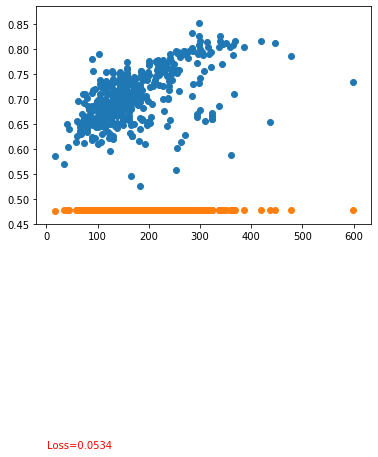

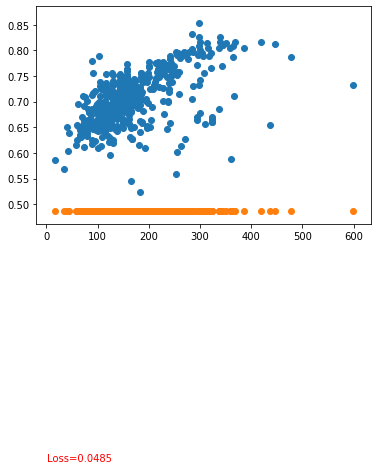

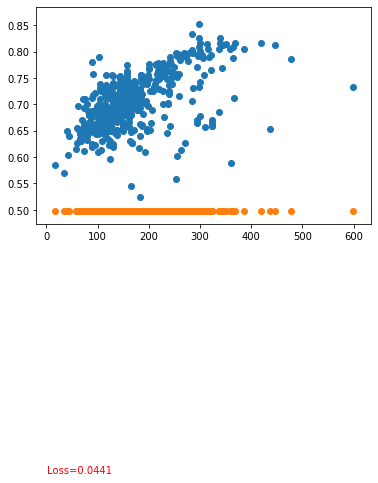

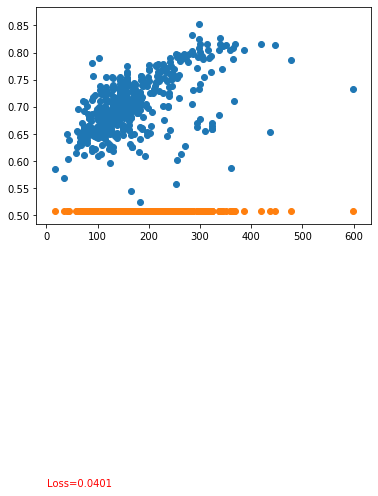

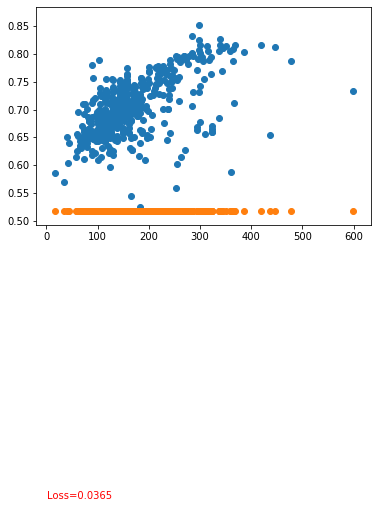

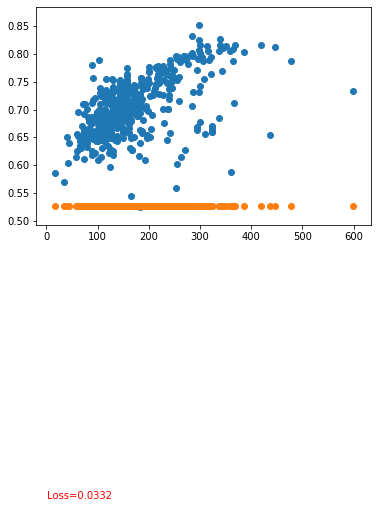

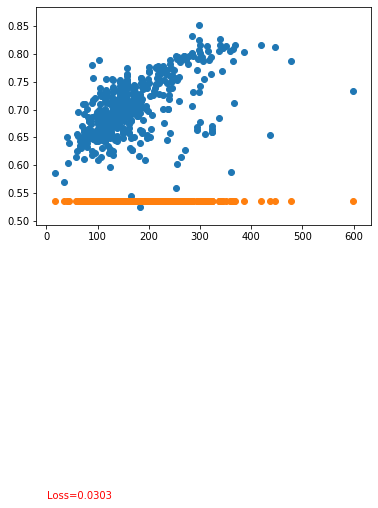

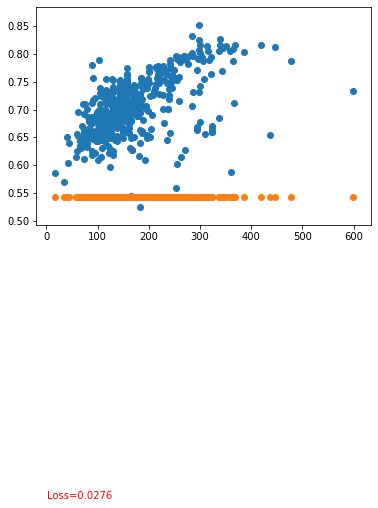

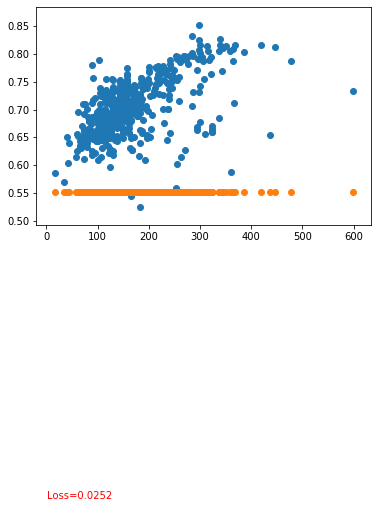

In [103]:
# now training and evaluating a neural network and plotting and validating results
plt.figure(3)
feature_matrix, label_matrix, training_range, test_range, validation_range =\
    neural_network_input_data_creator(features, reduced_temp)
model = neural_network_trainer(feature_matrix, label_matrix)
# neural_network_evaluator(mol_weight, reduced_temp, test_range, features, model)
# neural_network_evaluator(mol_weight, reduced_temp, validation_range, features, model)

In [104]:
# neural_network_validator()
# neural_network_plotter
# may add this in later

In [105]:
# # bringing up figures
# for i in range(1, 3):
#     plt.show(figure=i)

### END ###

In [106]:
# CALLING MAIN FUNCTION
#main()